# Exploratory Factor Analysis
Creating environmental practice "bundles" to test moderating effect and complementarity with JIT

### Imports & Directories

In [43]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import norm

In [3]:
current_dir = os.getcwd()
project_root = os.path.dirname(os.path.dirname(current_dir))
PROCESSED_DATA_PATH = os.path.join(project_root, 'data', 'processed')
RAW_DATA_PATH = os.path.join(project_root, 'data', 'raw')
OUTPUT_PATH = os.path.join(project_root, 'output')

### Get environmental practice variables only 

In [21]:
# Load the data (assuming you have a CSV file named 'data.csv')
data = pd.read_excel(RAW_DATA_PATH + '/HPM data_environmental performance.xlsx')

In [32]:
# if original_code in data begings with either ENVRTX or EPRACX take row and add to new dataframe
environmental_practices = pd.DataFrame()
for column in data.columns:
    if column.startswith('ENVRTX') or column.startswith('EPRACX'):
        environmental_practices[column] = data[column]

In [33]:
environmental_practices.head()

,ENVRTX21,ENVRTX37,ENVRTX02,ENVRTX22,ENVRTX39,ENVRTX23,ENVRTX18,ENVRTX13,ENVRTX33,ENVRTX03,...,ENVRTX31,ENVRTX35,ENVRTX36,ENVRTX06,EPRACX01,EPRACX02,EPRACX03,EPRACX04,EPRACX05,EPRACX06
0,4.0,2.0,4.0,3.0,3.0,5.0,2.0,3.0,2.0,4.0,...,3.0,3.0,2.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,2.0,3.0,1.0,2.0,4.0,3.0,4.0,NaN,4.0,...,2.0,4.0,2.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0
3,2.0,4.0,2.0,2.0,3.0,4.0,4.0,3.0,1.0,4.0,...,1.0,1.0,1.0,3.0,1.0,3.0,3.0,2.0,2.0,2.0
4,2.0,1.0,3.0,2.0,3.0,4.0,3.0,4.0,1.0,2.0,...,2.0,4.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0


### Map codes for human readable features 

In [34]:
# Load the JSON file containing the shorter descriptions
with open(PROCESSED_DATA_PATH + '/codes.json', 'r') as f:
    codes = json.load(f)

# Create a mapping of original codes to descriptive names
code_to_name = {item['original_code']: item['descriptive_name'] for item in codes}

# Rename columns using the shorter descriptions
environmental_practices.rename(columns=code_to_name, inplace=True)

In [39]:
environmental_practices.shape

(330, 41)

### Clean up dataframe

In [40]:
# Drop rows with missing values (or you can choose other imputation methods)
df_cleaned = environmental_practices.dropna()

# Assuming df_cleaned is the dataframe after dropping NaN values
numeric_cols = df_cleaned.select_dtypes(include=[float, int]).columns
df_numeric = df_cleaned[numeric_cols]

In [51]:
df_cleaned.head

<bound method NDFrame.head of      Environmentally Preferable Packaging  \
3                                     2.0   
4                                     2.0   
5                                     3.0   
6                                     3.0   
8                                     4.0   
..                                    ...   
321                                   4.0   
322                                   1.0   
323                                   4.0   
327                                   3.0   
328                                   3.0   

     Third Party Monitoring of Supplier Working Conditions  Water Efficiency  \
3                                                  4.0                   2.0   
4                                                  1.0                   3.0   
5                                                  3.0                   3.0   
6                                                  1.0                   3.0   
8                            

### Check suitability for EFA

In [44]:
# Check the suitability with a Bartlett’s test of sphericity and the Kaiser-Meyer-Olkin (KMO) test
df = df_numeric

chi_square_value, p_value = calculate_bartlett_sphericity(df)
kmo_all, kmo_model = calculate_kmo(df)

print(f"Bartlett’s test p-value: {p_value}")
print(f"KMO test: {kmo_model}")

Bartlett’s test p-value: 0.0
KMO test: 0.9349475413732526


/Users/john.anderson/hpm/.venv/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


[17.07634613  3.04291885  1.82868779  1.42301173  1.26146385  1.21542692
  1.07354664  1.00286029  0.86652988  0.84302299  0.79962298  0.74219347
  0.69731484  0.64419566  0.61425833  0.58389313  0.5286476   0.52079112
  0.49839987  0.45579278  0.43581021  0.40750914  0.37380962  0.36237445
  0.33884725  0.32825661  0.31629117  0.28521402  0.27899416  0.25513241
  0.24401762  0.2337336   0.21704476  0.19132966  0.18122909  0.17249084
  0.16761051  0.14037975  0.12835704  0.11866325  0.10398001]


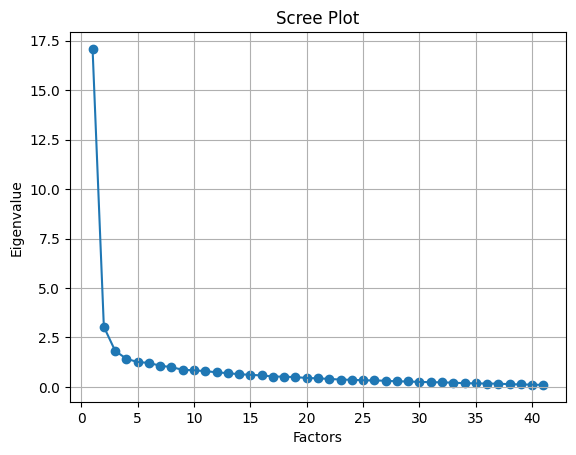

In [45]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(df)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
print(ev)

# Plot the eigenvalues
plt.scatter(range(1, df.shape[1]+1), ev)
plt.plot(range(1, df.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


Elbow method is questionable but will use it for now

In [53]:
n_factors=5

# Perform factor analysis using the number of factors you decided on
fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")
fa.fit(df)

# Check the loadings (correlation coefficients between observed variables and latent common factors)
loadings = fa.loadings_
# print(loadings)

# Get variance of each factors
fa_variance = fa.get_factor_variance()
# print(fa_variance)


### Visualise the results

In [54]:
loadings_df = pd.DataFrame(loadings, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])],
                            index=df_numeric.columns)

# Create a DataFrame to store the results similar to the one you used for CFA
data = {
    'Item': [],
    'Factor1 Loading': [],
    'Factor2 Loading': [],  # Extend this if you have more factors
    # 'Factor3 Loading': [],  # Uncomment if necessary
    # Add more factors as necessary
    'Communalities': [],
    'Uniqueness': []
}

# Assuming that df_numeric.columns is a list of item descriptions
for item in df_numeric.columns:
    item_loadings = loadings_df.loc[item].values  # Loadings for this item
    item_comm = fa.get_communalities()[df_numeric.columns.get_loc(item)]  # Communality for this item
    item_uniq = fa.get_uniquenesses()[df_numeric.columns.get_loc(item)]  # Uniqueness for this item

    data['Item'].append(item)
    data['Factor1 Loading'].append(item_loadings[0])
    data['Factor2 Loading'].append(item_loadings[1])  # Add lines like this for additional factors
    # data['Factor3 Loading'].append(item_loadings[2])  # Uncomment if you have a third factor, etc.
    data['Communalities'].append(item_comm)
    data['Uniqueness'].append(item_uniq)

# Convert the data to a DataFrame
results_df = pd.DataFrame(data)

print(results_df)

                                                 Item  Factor1 Loading  \
0                Environmentally Preferable Packaging         0.405028   
1   Third Party Monitoring of Supplier Working Con...         0.542336   
2                                    Water Efficiency         0.317012   
3   Substituting Environmentally Preferable Direct...         0.404158   
4    Environmental Design Specifications to Suppliers         0.516131   
5   Environmental Improvements for Scrap/Excess Ma...         0.137012   
6        Customer Environmental Objectives Assistance         0.568538   
7                   Customer Supplier Code Compliance         0.384532   
8              Formal M/WBE Supplier Purchase Program         0.617320   
9                Reducing Waste in Internal Processes         0.305930   
10                                Life-cycle Analysis         0.572355   
11  Environmental Considerations in Supplier Evalu...         0.532022   
12           Decreasing Environmental 

In [55]:
# To save the results to a CSV file
results_df.to_csv(OUTPUT_PATH + '/ep_efa_results.csv', index=False)